In [1]:
import d6tflow
import luigi
from luigi.util import inherits

import sklearn
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

import time
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', 500)

from SpotifyQueries.WorldTopTracks import queryWorldTopTracks

Loading postgres module without psycopg2 installed. Will crash at runtime if postgres functionality is used.
Loading S3 module without the python package boto3. Will crash at runtime if S3 functionality is used.


Welcome to d6tflow!


# Load data

### Download relevant data through the Spotipy API

For readability this is done in a separate file

### and set target class for songs that i like = 1, and dislike = 0

In [2]:
class TaskGetLikedSongs(d6tflow.tasks.TaskPqPandas):  # save dataframe as parquet

    def run(self):
        df_likes = pd.read_csv('my_top_135.csv',index_col=0)
        df_likes['target'] = 1
        self.save(df_likes)

In [3]:
class TaskGetDisikedSongs(d6tflow.tasks.TaskPqPandas):

    def run(self):
        #df_dislikes = pd.read_csv('world_top_135.csv',index_col=0)
        df_dislikes = queryWorldTopTracks()
        df_dislikes['target'] = 0
        self.save(df_dislikes)

# Combine data

In [4]:
class TaskCombineData(d6tflow.tasks.TaskPqPandas):

    # define dependencies
    def requires(self):
        return {'liked':TaskGetLikedSongs(), 
                'disliked':TaskGetDisikedSongs()}

    def run(self):
        df_likes = self.input()['liked'].load() # load required data
        df_dislikes = self.input()['disliked'].load()

        data = pd.concat([df_likes, df_dislikes],sort=False).reset_index()
        data = data.drop(columns=['index'], axis=1)
        
        self.save(data)

# Extract numeric data columns and normalize
### (machine learning requires numeric values)

In [5]:
class TaskExtractTrainingData(d6tflow.tasks.TaskPickle):
    do_preprocess = luigi.BoolParameter(default=True) # parameter for preprocessing

    persist=['training_data','features'] # tell d6tflow what the class should save

    def requires(self):
        return TaskCombineData()

    def run(self):
        data = self.input().load()
        
        training_data = data._get_numeric_data()
        features = training_data.drop(columns=['target'], axis=1).columns

        
        if self.do_preprocess:
            from sklearn.preprocessing import StandardScaler
            sc = StandardScaler()
            scaled_data = sc.fit_transform(training_data)
            training_data = pd.DataFrame(scaled_data, columns=training_data.columns)
        
        self.save({'training_data':training_data,'features':features})

In [6]:
@inherits(TaskExtractTrainingData) # this will auto-pass parameters up to parent
class TaskSplitTrainTest(d6tflow.tasks.TaskPickle):
    test_size = luigi.FloatParameter(default=0.2)

    persist=['train','test','training_data','features']
    
    def requires(self):
        return self.clone_parent()

    def run(self):
        training_data = self.input()['training_data'].load()
        features = self.input()['features'].load()

        train, test = train_test_split(training_data, test_size=self.test_size)
        
        self.save({
            'train':train, 'test':test,
            'training_data':training_data,'features':features
        })

In [7]:
@inherits(TaskSplitTrainTest)
class TaskTrain(d6tflow.tasks.TaskPickle):
    number_of_trees_in_forest = luigi.FloatParameter(default=1000)
    random_state = luigi.IntParameter(default=None)

    def requires(self):
        return self.clone_parent()

    def run(self):
        training_data = self.input()['training_data'].load()
        features = self.input()['features'].load()
        train = self.input()['train'].load()
        test = self.input()['test'].load()
        
        model = RandomForestClassifier(
            self.number_of_trees_in_forest,
            random_state=self.random_state)
        
        model.fit(train[features],train['target'])
        
        self.save(model)

# Check process status

In [12]:
d6tflow.preview(TaskTrain(do_preprocess=1500))


└─--[TaskTrain-{'do_preprocess': 'False', 'test_size': '0.2', 'number_of_trees_in_forest': '1000', 'random_state': 'None'} (PENDING)]
   └─--[TaskSplitTrainTest-{'do_preprocess': 'False', 'test_size': '0.2'} (PENDING)]
      └─--[TaskExtractTrainingData-{'do_preprocess': 'False'} (PENDING)]
         └─--[TaskCombineData-{} (COMPLETE)]
            |--[TaskGetLikedSongs-{} (COMPLETE)]
            └─--[TaskGetDisikedSongs-{} (COMPLETE)]


### Optionally force rerun of process

In [ ]:
TaskSplitTrainTest().invalidate(confirm=False)

In [ ]:
TaskTrain().invalidate(confirm=False)

# Run full pipeline
### Previously run steps are cached and does not need to be run if not changed

In [18]:
d6tflow.run(TaskTrain(number_of_trees_in_forest=2000))

INFO: Informed scheduler that task   TaskTrain_True_2000_None_ecc607e57f   has status   PENDING
INFO: Informed scheduler that task   TaskSplitTrainTest_True_0_2_e6b028f96c   has status   DONE
INFO: Done scheduling tasks
INFO: Running Worker with 1 processes
INFO: [pid 129] Worker Worker(salt=794558143, workers=1, host=3852df2bc28c, username=adriant92, pid=129) running   TaskTrain(do_preprocess=True, test_size=0.2, number_of_trees_in_forest=2000, random_state=None)
INFO: [pid 129] Worker Worker(salt=794558143, workers=1, host=3852df2bc28c, username=adriant92, pid=129) done      TaskTrain(do_preprocess=True, test_size=0.2, number_of_trees_in_forest=2000, random_state=None)
INFO: Informed scheduler that task   TaskTrain_True_2000_None_ecc607e57f   has status   DONE
INFO: Worker Worker(salt=794558143, workers=1, host=3852df2bc28c, username=adriant92, pid=129) was stopped. Shutting down Keep-Alive thread
INFO: 
===== Luigi Execution Summary =====

Scheduled 2 tasks of which:
* 1 complete on

True

# Extract results and intermediate variables

In [19]:
model = TaskTrain().output().load()

In [20]:
df_test = TaskSplitTrainTest().output()['test'].load()
df_train = TaskSplitTrainTest().output()['train'].load()
training_data = TaskSplitTrainTest().output()['training_data'].load()
features = TaskSplitTrainTest().output()['features'].load()
training_data_raw = TaskCombineData().output().load()

# Compare features for songs i like and dislike

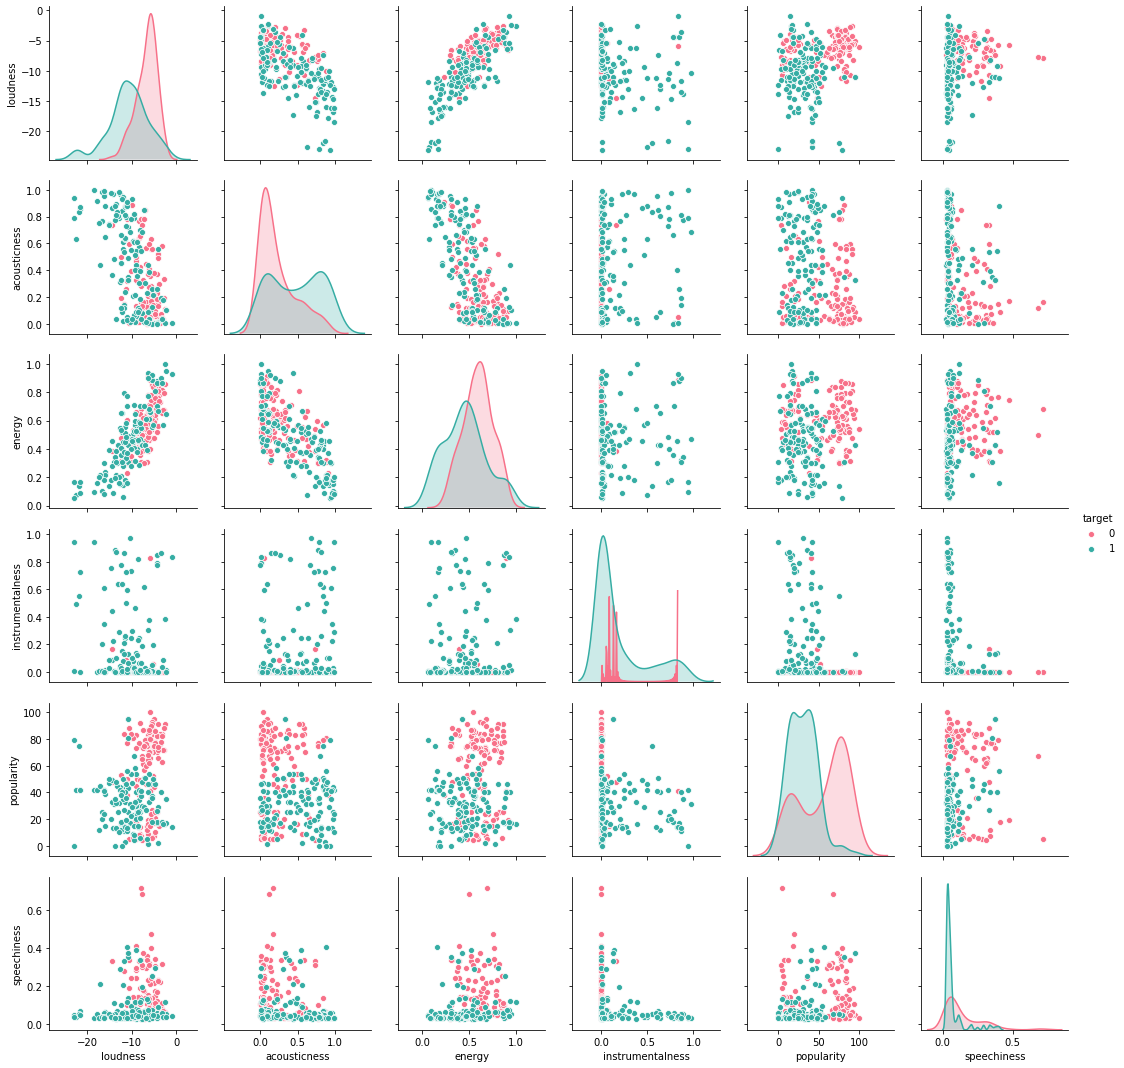

In [73]:
sns.pairplot(training_data,
             vars=['loudness','acousticness',
                    'energy','instrumentalness', 
                    'popularity','speechiness'],
             hue='target',
             palette="husl")

# Compute accuracy

In [21]:
y_pred = model.predict(df_test[features])
accuracy = sklearn.metrics.accuracy_score(df_test['target'],y_pred)
print("accuracy: %.1f%%" % (accuracy*100))

accuracy: 83.3%


In [17]:
report = classification_report(df_test['target'],y_pred, output_dict=True)
df_report = pd.DataFrame(report).transpose()
df_report

precision    recall  f1-score    support
-1.0           0.888889  0.800000  0.842105  30.000000
1.0            0.777778  0.875000  0.823529  24.000000
accuracy       0.833333  0.833333  0.833333   0.833333
macro avg      0.833333  0.837500  0.832817  54.000000
weighted avg   0.839506  0.833333  0.833849  54.000000

# Check feature importance

In [22]:
import operator
my_list = list(zip(df_train[features], model.feature_importances_))
my_list.sort(key = operator.itemgetter(1),reverse = True)

In [23]:
pd.DataFrame(model.feature_importances_,df_train[features].columns,
             columns = ['importance']).sort_values(by='importance', ascending=False)

importance
instrumentalness    0.294919
popularity          0.146656
danceability        0.120122
loudness            0.117235
energy              0.057607
speechiness         0.048742
duration_ms         0.048070
acousticness        0.044845
valence             0.040557
tempo               0.032118
liveness            0.026223
key                 0.013068
time_signature      0.005174
mode                0.004663

# See test results

In [24]:
probs = model.predict_proba(df_test[features])
test_full = training_data_raw.loc[df_test.index][['track_name','artist']]
test_full["like"], test_full["dislike"] = probs[:,1], probs[:,0]
test_full.sort_values(by="dislike")

track_name           artist  \
63                                           Afterglow           Ásgeir   
97                                             Unbound           Ásgeir   
126                  Salen så helt annerledes ut i går            No. 4   
104                                      Underneath It           Ásgeir   
34                                               Sleep          Son Lux   
92                                     Luck's Gone Bad         Woodland   
26                                               Sorry             Hajk   
121                                      Forty Screams          Son Lux   
83                              American Death Express   Dirty Art Club   
100                                              Perth         Bon Iver   
74                       All Night Long (feat. Take 6)    Jacob Collier   
75   I Am All That I Need / Arroyo Seco / Thumbprin...      Fleet Foxes   
53                           With The Love In My Heart    Jacob Collier   
54                                      Your Protector      Fleet Foxes   
155                                            bad guy    Billie Eilish   
156                                 Don’t Matter To Me            Drake   
78                                        The Crossing   Dirty Art Club   
187                                       Passionfruit            Drake   
93                                              Slowly          Son Lux   
106                                           Reminder          Moderat   
28                                  listen before i go    Billie Eilish   
123                                            Familie            No. 4   
248                            Wake Me Up - Radio Edit           Avicii   
246  the remedy for a broken heart (why am I so in ...     XXXTENTACION   
39                                              Flower             Fieh   
206                                           bad idea    Ariana Grande   
108                                              I Got  Young the Giant   
178           It's the Most Wonderful Time of the Year    Andy Williams   
176                                           Mob Ties            Drake   
29                                         Best Friend             Hajk   
145                                     Last Christmas            Wham!   
98                      Lover, You Should've Come Over     Jeff Buckley   
153                                        Emotionless            Drake   
157                                           rockstar      Post Malone   
139                                               SAD!     XXXTENTACION   
163                                  MIA (feat. Drake)        Bad Bunny   
177                                        I'm the One        DJ Khaled   
209                                           CAROUSEL     Travis Scott   
214                                           Mi Gente         J Balvin   
186                                  Can’t Take A Joke            Drake   
20                                  Toyota'n til Magdi            Karpe   
158                                         STARGAZING     Travis Scott   
235             FEFE (feat. Nicki Minaj & Murda Beatz)          6ix9ine   
237                                           All Mine       Kanye West   
188                                               NASA    Ariana Grande   
222                                          Con Calma     Daddy Yankee   
260                                            imagine    Ariana Grande   
232                                                ATM          J. Cole   
170                                           Paranoid      Post Malone   
243                                          New Rules         Dua Lipa   
195                             I Love It (& Lil Pump)       Kanye West   
212      Sunflower - Spider-Man: Into the Spider-Verse      Post Malone   
241                    Let It Fly (feat. Travis Scott)        Lil Way

# Plot Descision Tree

In [76]:
if not os.path.exists("tree.png"):
    estimator = model.estimators_[5]

    from sklearn.tree import export_graphviz
    # Export as dot file
    export_graphviz(estimator, out_file='tree.dot', 
                    feature_names = features,
                    class_names = ['Dislike','Like'],
                    rounded = True, proportion = False, 
                    precision = 2, filled = True)

    from subprocess import call
    call(['dot', '-Tpng', 'tree.dot', '-o', 'tree.png', '-Gdpi=600'])

In [77]:
from IPython.display import Image
Image(filename = 'tree.png')